In [719]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

class GCMSDataEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class SensorDataEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [720]:
# uploading gcms data
df = pd.read_csv("gcms_dataframe.csv")

# adding ambient to the df
ambient_row = pd.DataFrame([{'food_name': "ambient", 'C': 0.04, "Ca": 0, "H": 0.00005, "K": 0, "Mg": 0, "N": 78.08, "Na":0, "O": 20.95, "P": 0, "Se":0,}])

df = pd.concat([df, ambient_row], ignore_index=True)

# getting rid of names and keeping only numerical values
top_5_food = ["oregano", "cumin", "cloves", "ambient"]
# top_5_food = ["coffee_beans", "oregano", "mint_leaves", "apple_juice", "cloves"]

df = df[df['food_name'].isin(top_5_food)]

df_dropped = df.drop(columns=["food_name"], errors="ignore")

gcms_data = df_dropped.values

scaler = StandardScaler()

scaler.fit(gcms_data)

gcms_data = scaler.transform(gcms_data)

available_food_names = df["food_name"].to_list()

ix_to_name = {i: name for i, name in enumerate(available_food_names)}
name_to_ix = {name: i for i, name in enumerate(available_food_names)}

In [721]:
ix_to_name

{0: 'cloves', 1: 'cumin', 2: 'oregano', 3: 'ambient'}

In [722]:
available_food_names

['cloves', 'cumin', 'oregano', 'ambient']

In [723]:
# loading smell sensor data || Training?
smell_data_path = "demo_data"

paths = []

for file in os.listdir(smell_data_path):
    file_path = os.path.join(smell_data_path, file)
    food_name = file.split(".")[0]

    if food_name in available_food_names:
        paths.append(file_path)

print(paths)

['demo_data/cloves.0d69202791d1.csv', 'demo_data/ambient.61a9318b12d6.csv', 'demo_data/oregano.a44fda9f8acd.csv', 'demo_data/cumin.ff6de217fab1.csv']


In [724]:
# loading smell sensor data from real_time_data || Real-time testing?
real_time_data_path = "demo_data/real_time_data"

paths_testing = []

# Iterate through subdirectories in real_time_data
for subdir in os.listdir(real_time_data_path):
    subdir_path = os.path.join(real_time_data_path, subdir)
    
    # Skip if not a directory
    if not os.path.isdir(subdir_path):
        continue
    
    # Iterate through CSV files in each subdirectory
    for file in os.listdir(subdir_path):
        if file.endswith('.csv'):
            file_path = os.path.join(subdir_path, file)
            file_name = file.split(".")[0]
            food_name = file_name.split("_")[0]

            # Check against available food names
            if food_name in available_food_names:
                paths_testing.append(file_path)
print(paths_testing)
print(f"there are {len(paths_testing)} new data files!")

['demo_data/real_time_data/oregano_glass/oregano_glass.a4d3bbffd4ef.csv', 'demo_data/real_time_data/oregano_glass/oregano_glass.5fca30e6e540.csv', 'demo_data/real_time_data/oregano_glass/oregano_glass.24df5bcabd1c.csv', 'demo_data/real_time_data/cloves_glass/cloves_glass.27993efaea33.csv', 'demo_data/real_time_data/cloves_glass/cloves_glass.f6b95a431a64.csv', 'demo_data/real_time_data/cloves_glass/cloves_glass.2aee44ab85a8.csv', 'demo_data/real_time_data/cloves_glass/cloves_glass.0c7fd0730d78.csv', 'demo_data/real_time_data/ambient_glass/ambient_glass.34719a15e673.csv', 'demo_data/real_time_data/ambient_glass/ambient_glass.8d4bd93322fe.csv', 'demo_data/real_time_data/ambient_glass/ambient_glass.9e700bd37fab.csv', 'demo_data/real_time_data/cumin_glass/cumin_glass.e54f77e30989.csv', 'demo_data/real_time_data/cumin_glass/cumin_glass.adecc8192a2c.csv', 'demo_data/real_time_data/cumin_glass/cumin_glass.0b21d30914a9.csv']
there are 13 new data files!


In [725]:
def create_state_average_df(df):
    df['Group'] = (df['State'] != df['State'].shift()).cumsum()

    averaged_df = df.groupby('Group').mean().reset_index()

    averaged_df['State'] = df.groupby('Group')['State'].first().values

    averaged_df = averaged_df.drop(columns=['Group'])

    averaged_df = averaged_df[averaged_df["State"] < 2]
    averaged_df.reset_index(drop=True)
    return averaged_df

In [726]:
def calculate_state_difference(df):
    # Check if the first row's state is not 1 and remove it if true
    if df.iloc[0]['State'] != 1:
        df = df.iloc[1:].reset_index(drop=True)

    # Ensure the DataFrame has an even number of rows
    if len(df) % 2 != 0:
        df = df[:-1]

    # Calculate the difference between odd and even rows
    odd_rows = df.iloc[1::2].reset_index(drop=True)
    even_rows = df.iloc[0::2].reset_index(drop=True)

    result = odd_rows - even_rows
    return result

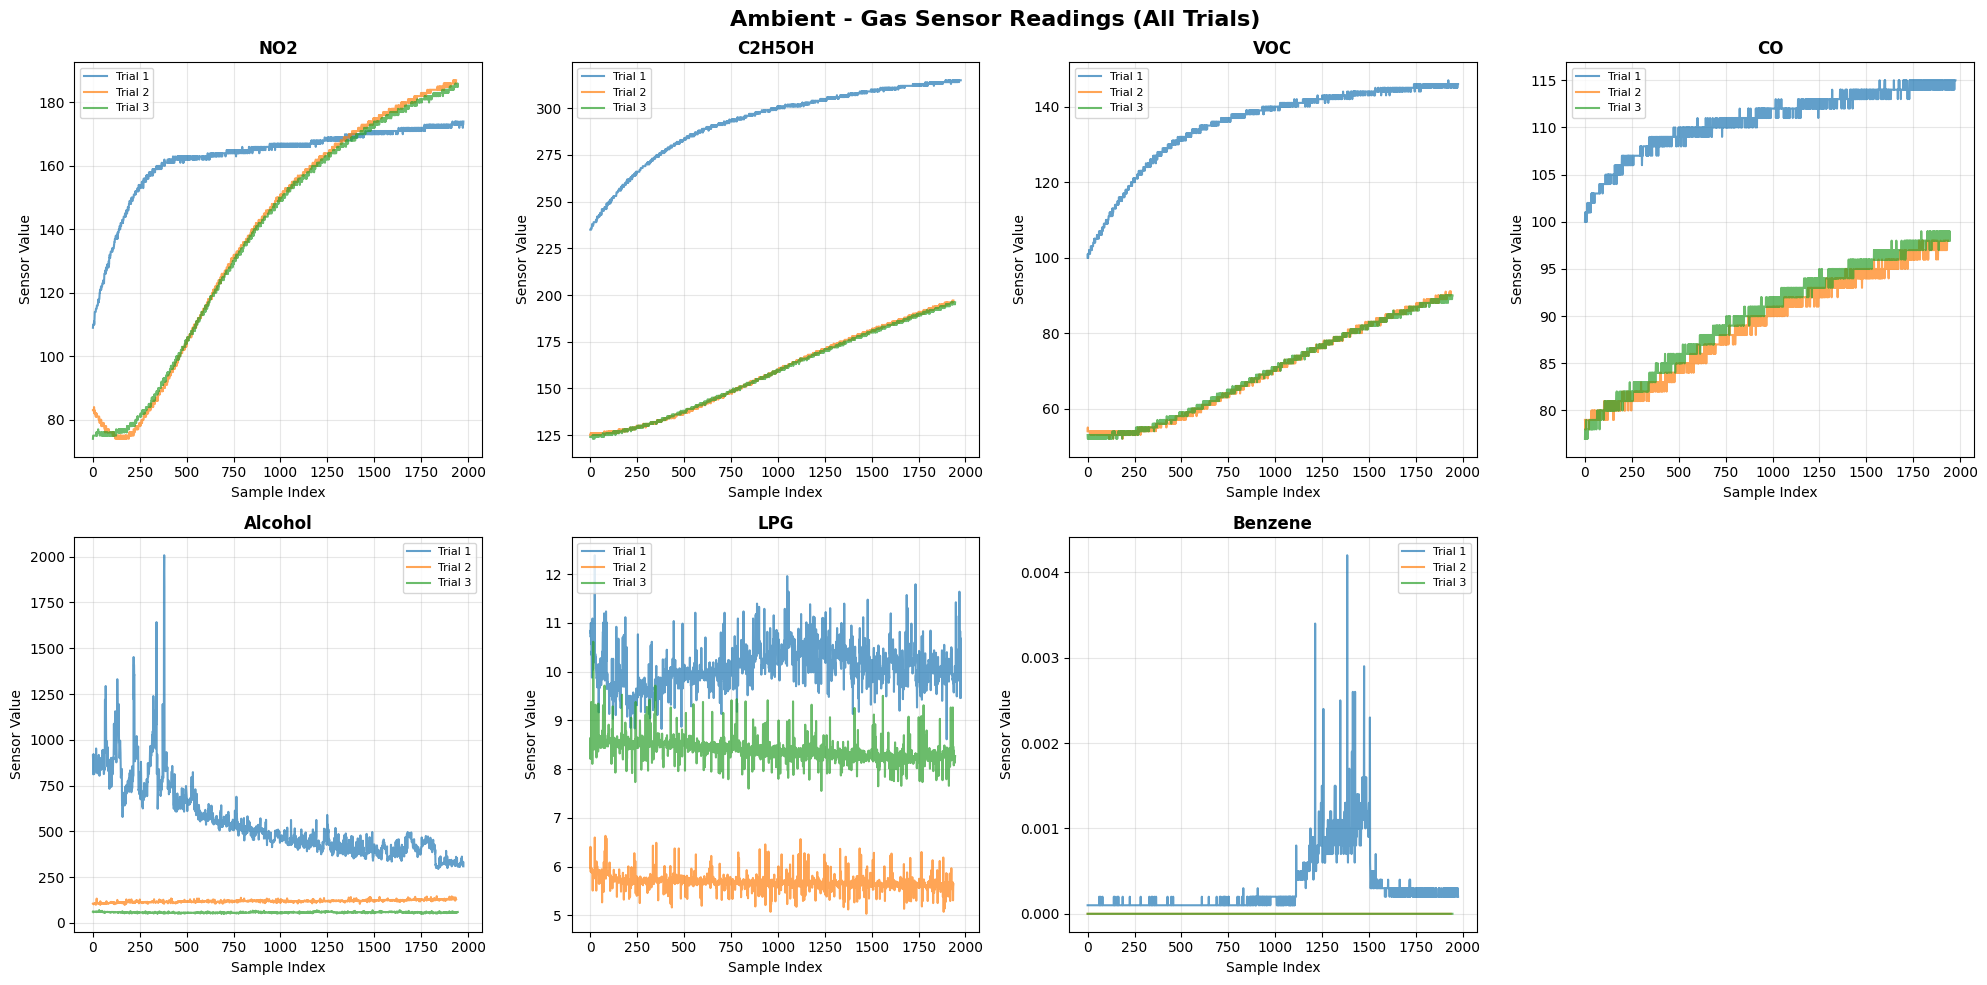

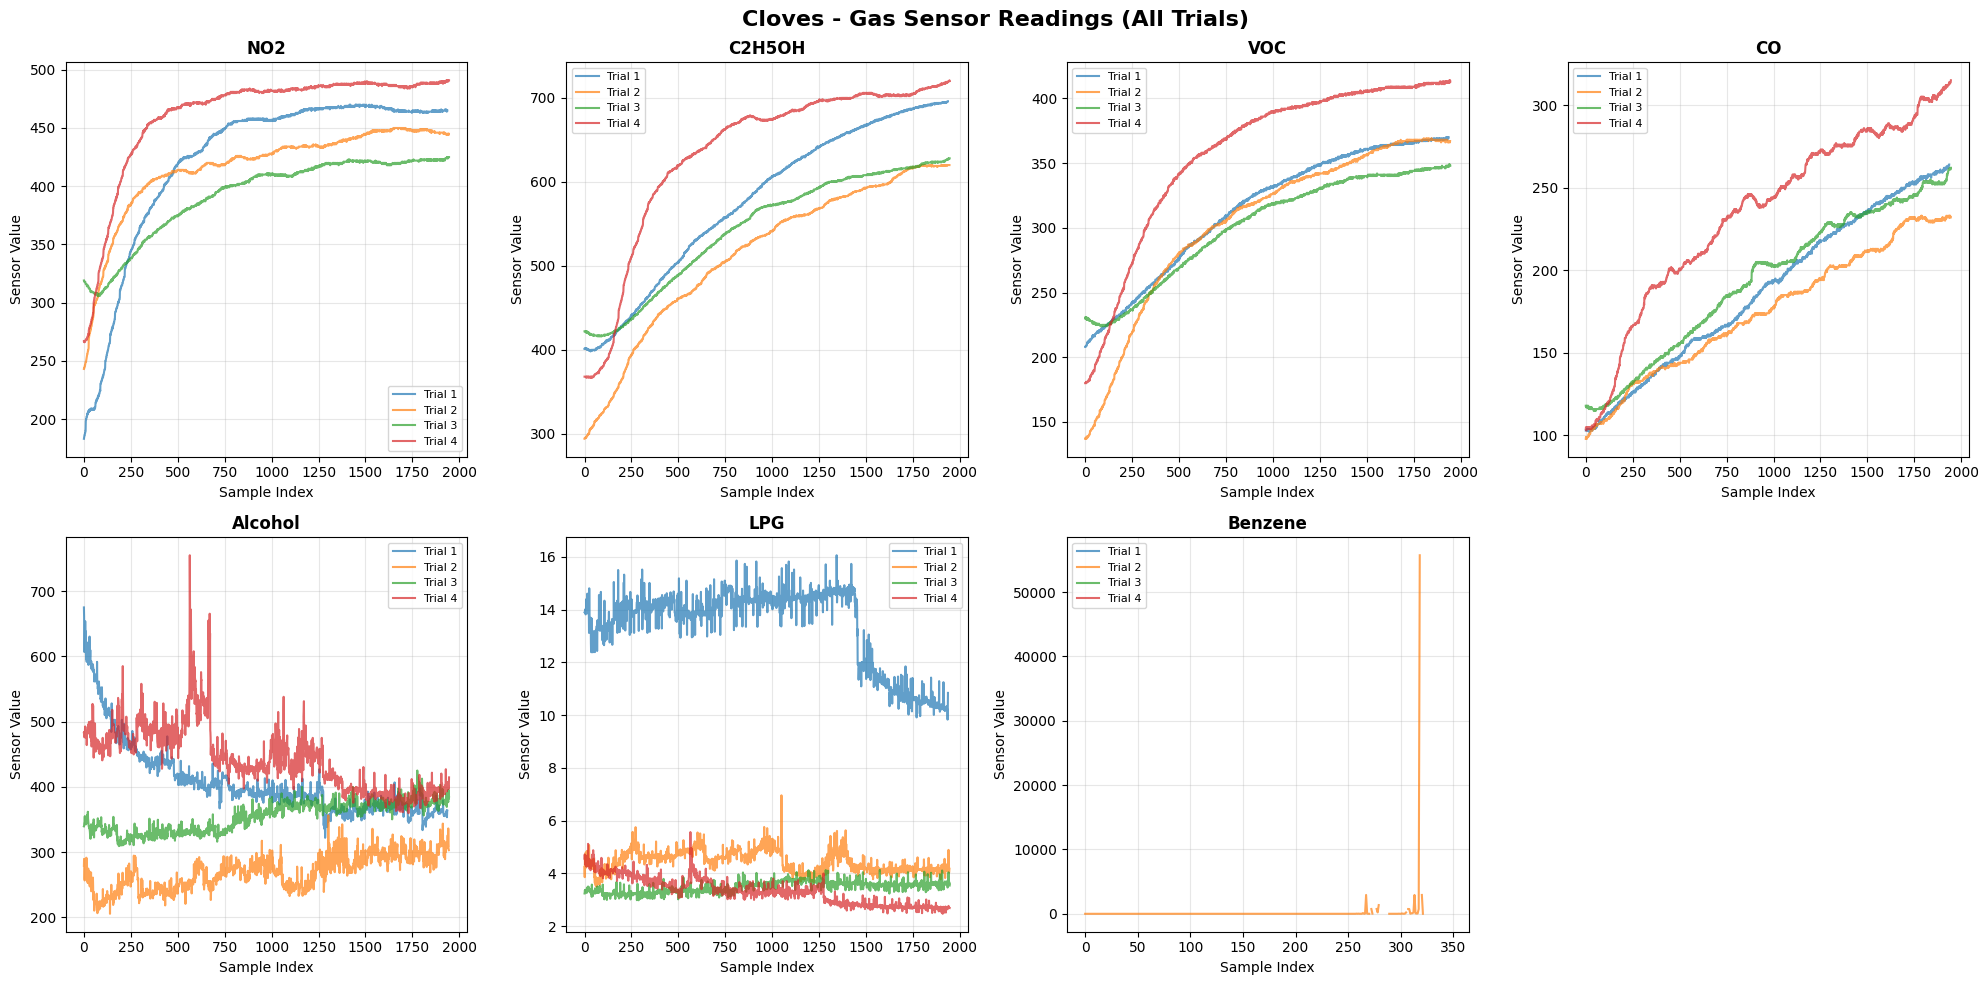

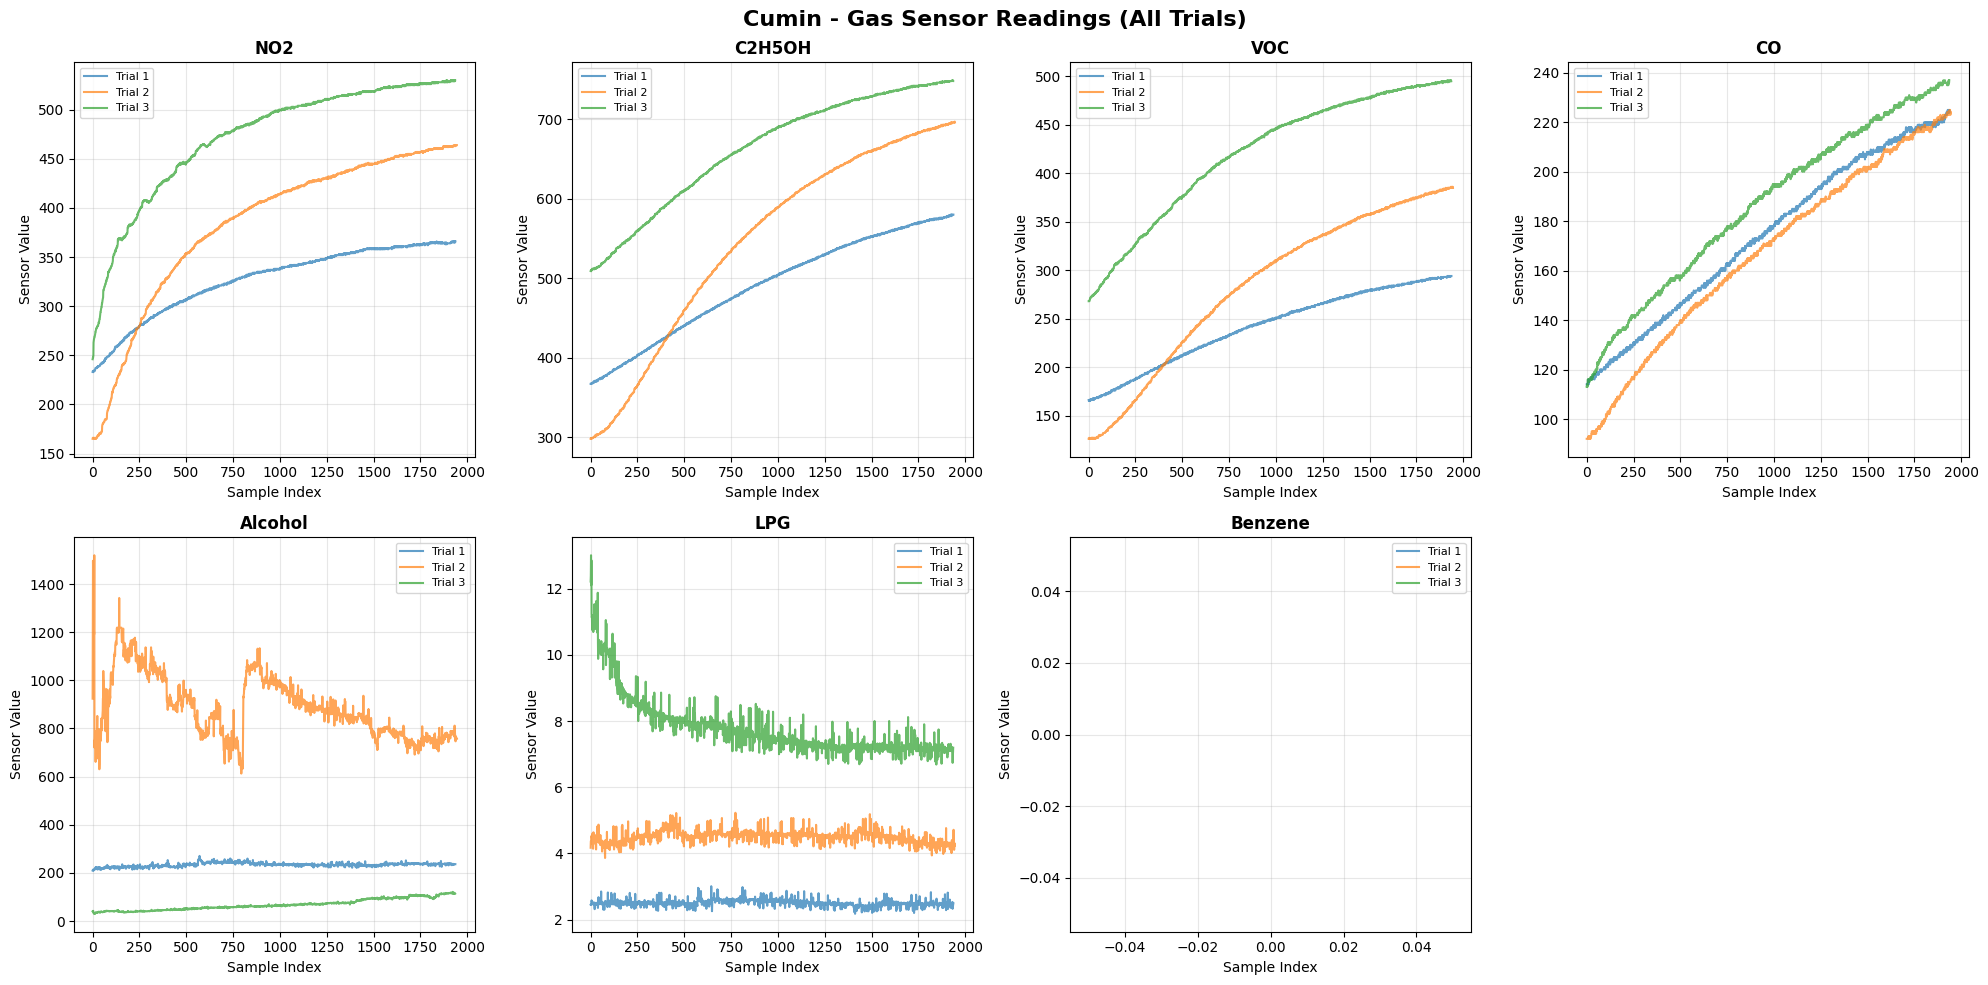

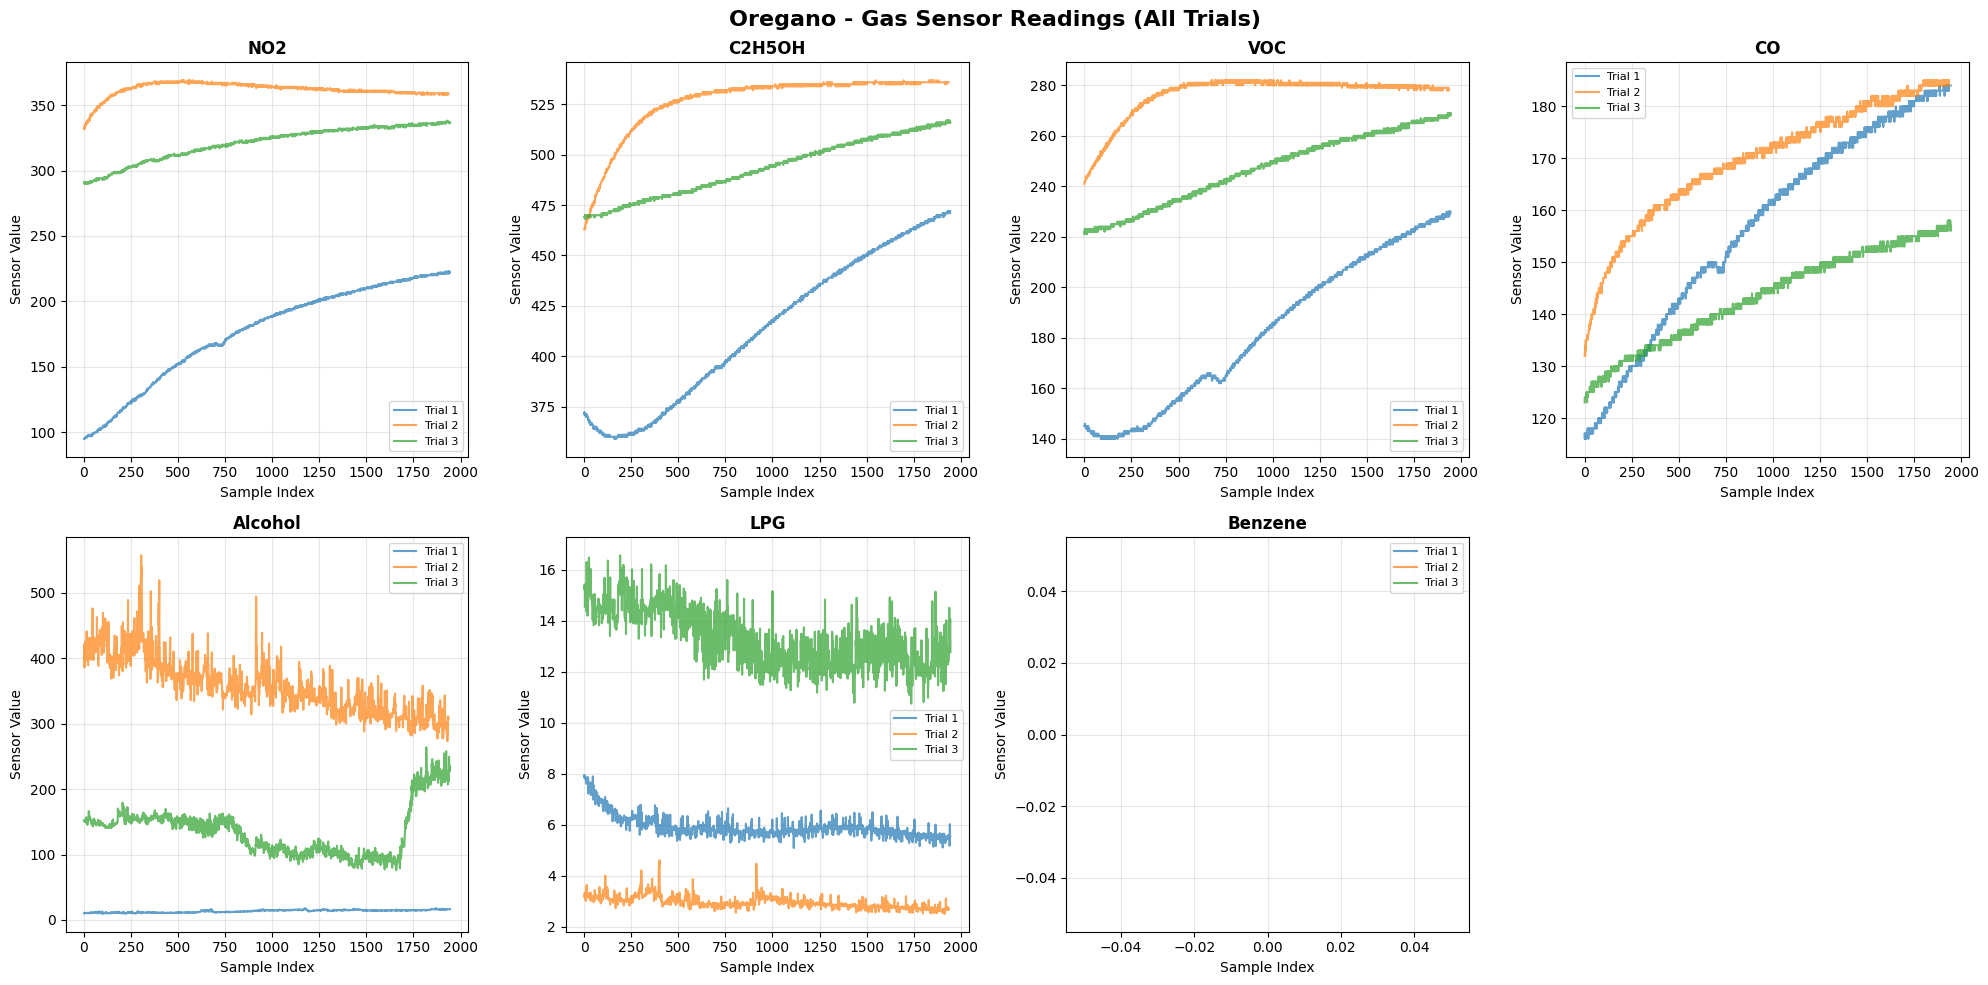

In [727]:
# data visualization to see which columns to keep for training

import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Columns to visualize, dropping temp, pressure, humidity, and altitude for now
gas_columns = ['NO2', 'C2H5OH', 'VOC', 'CO', 'Alcohol', 'LPG', 'Benzene']

def visualize_spice_trials(spice_name, data_path="demo_data/real_time_data"):
    """
    Create a grid of plots showing all trials for a particular spice
    Each subplot shows one sensor, with all trials overlaid
    """
    # Get all CSV files for this spice
    spice_dir = os.path.join(data_path, f"{spice_name}_glass")
    csv_files = sorted(glob.glob(os.path.join(spice_dir, "*.csv")))
    
    # Create figure with subplots (2 rows x 4 cols to fit 7 sensors)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(f'{spice_name.title()} - Gas Sensor Readings (All Trials)', 
                 fontsize=16, fontweight='bold')
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Plot each sensor column
    for idx, sensor in enumerate(gas_columns):
        ax = axes[idx]
        
        # Plot each trial/file
        for file_idx, csv_file in enumerate(csv_files):
            df = pd.read_csv(csv_file)
            file_label = f"Trial {file_idx + 1}"
            ax.plot(df[sensor], alpha=0.7, label=file_label, linewidth=1.5)
        
        ax.set_title(sensor, fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Sensor Value')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide the last subplot (we only need 7, but have 8 spaces)
    axes[7].set_visible(False)
    
    plt.tight_layout()
    return fig

# Example usage for all spices
spices = ['ambient', 'cloves', 'cumin', 'oregano']

for spice in spices:
    fig = visualize_spice_trials(spice)
    # Save the figure
    plt.savefig(f'demo_data/real_time_data/{spice}_analysis.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

In [728]:
gas_columns = ['NO2', 'C2H5OH', 'VOC', 'CO']
spices = ['ambient', 'cloves', 'cumin', 'oregano']
def visualize_csv_files(csv_files, title="Gas Sensor Readings"):
    # Create figure with subplots (2 rows x 4 cols to fit 7 sensors)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Plot each sensor column
    for idx, sensor in enumerate(gas_columns):
        ax = axes[idx]
        
        # Plot each file
        for file_idx, csv_file in enumerate(csv_files):
            df = pd.read_csv(csv_file)
            file_label = f"{spices[file_idx]}"
            ax.plot(df[sensor], alpha=0.7, label=file_label, linewidth=1.5)
        
        ax.set_title(sensor, fontsize=12, fontweight='bold')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Sensor Value')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide the last subplot
    axes[7].set_visible(False)
    
    plt.tight_layout()
    return fig


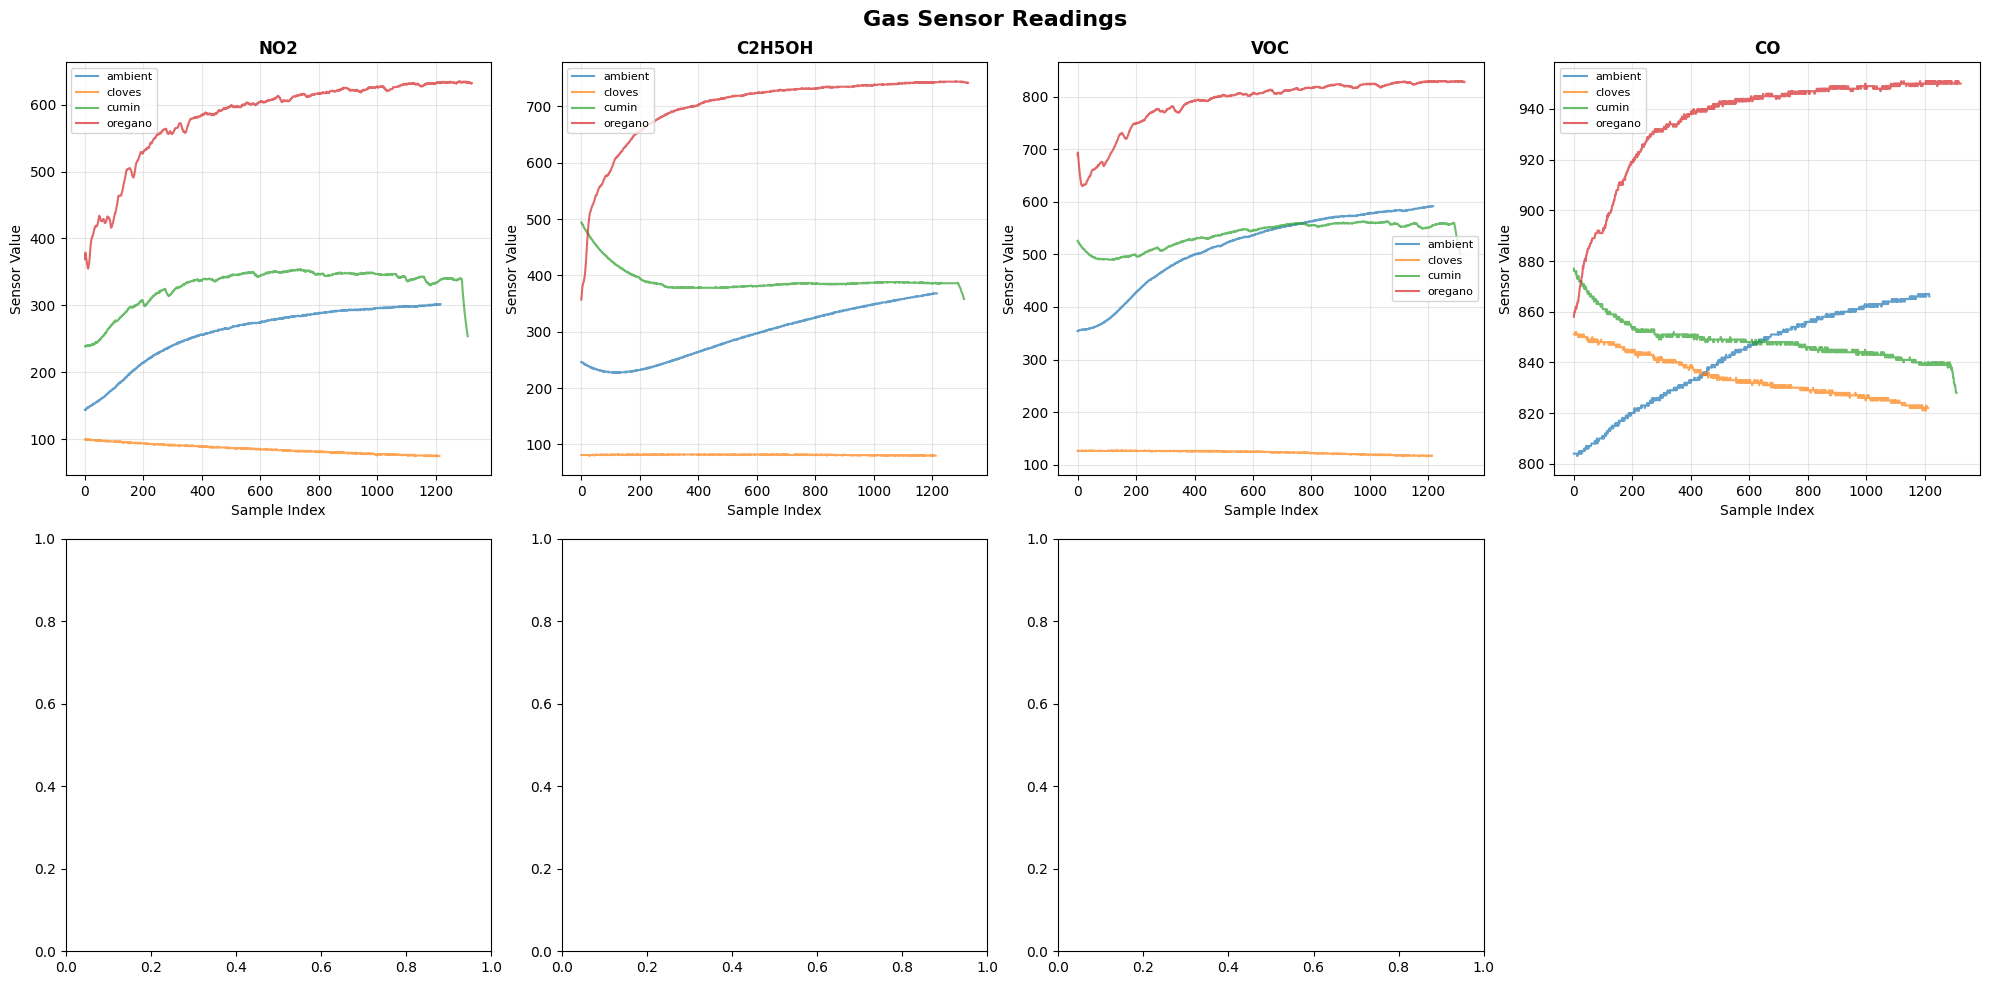

In [729]:
# Example usage for all spices
spices = ['ambient', 'cloves', 'cumin', 'oregano']

#for path in paths:
fig = visualize_csv_files(csv_files = paths)
    # Save the figure
    #spice = path.split(".")[0]
plt.show()

In [730]:
from collections import defaultdict
import re

ingredient_df = []

for path in paths_testing:
    print(path)
    ingredient_name = re.split(r'[./]', path)[-3]
    ingredient_name = ingredient_name.split("_")[0]
    dataframe = pd.read_csv(path)
    if dataframe.shape[1] > 14:
        dataframe = dataframe[dataframe.columns[:14]]
        
    # print(f"for path {path} the columns are {dataframe.columns}")
    print(dataframe.columns)
    # dataframe.drop(columns=["Temperature", "Pressure", "Humidity", "Gas_Resistance", "Altitude", "Alcohol", "LPG", "Benzene"], inplace=True)
    dataframe = dataframe[gas_columns]
    dataframe.rename(columns={dataframe.columns[-1]: "State"}, inplace=True)

    diff_data = dataframe.diff(periods=50)  # This is the key change

    sensor_cols = [col for col in diff_data.columns if col not in ["State", "label"]]
    diff_data = diff_data[~(diff_data[sensor_cols] == 0).all(axis=1)]

    # Drop the first 10 rows with NaN values
    diff_data = diff_data.iloc[200:-200]

    diff_data["label"] = name_to_ix[ingredient_name]
    ingredient_df.append(diff_data)

demo_data/real_time_data/oregano_glass/oregano_glass.a4d3bbffd4ef.csv
Index(['NO2', 'C2H5OH', 'VOC', 'CO', 'Alcohol', 'LPG', 'Benzene',
       'Temperature', 'Pressure', 'Humidity', 'Gas_Resistance', 'Altitude'],
      dtype='object')
demo_data/real_time_data/oregano_glass/oregano_glass.5fca30e6e540.csv
Index(['NO2', 'C2H5OH', 'VOC', 'CO', 'Alcohol', 'LPG', 'Benzene',
       'Temperature', 'Pressure', 'Humidity', 'Gas_Resistance', 'Altitude'],
      dtype='object')
demo_data/real_time_data/oregano_glass/oregano_glass.24df5bcabd1c.csv
Index(['NO2', 'C2H5OH', 'VOC', 'CO', 'Alcohol', 'LPG', 'Benzene',
       'Temperature', 'Pressure', 'Humidity', 'Gas_Resistance', 'Altitude'],
      dtype='object')
demo_data/real_time_data/cloves_glass/cloves_glass.27993efaea33.csv
Index(['NO2', 'C2H5OH', 'VOC', 'CO', 'Alcohol', 'LPG', 'Benzene',
       'Temperature', 'Pressure', 'Humidity', 'Gas_Resistance', 'Altitude'],
      dtype='object')
demo_data/real_time_data/cloves_glass/cloves_glass.f6b95a431a6

In [731]:
combined_df = pd.concat(ingredient_df, axis=0, ignore_index=True)

In [732]:
columns_to_normalize = combined_df.columns[:13]

In [733]:
def filter_outliers(group):
    numerical_columns = group.select_dtypes(include=[np.number]).columns
    for col in numerical_columns:
        Q1 = group[col].quantile(0.2)
        Q3 = group[col].quantile(0.8)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group = group[(group[col] >= lower_bound) & (group[col] <= upper_bound)]
    return group

# Group by 'Label' and filter outliers within each group
# filtered_groups = combined_df.groupby('label').apply(filter_outliers).reset_index(drop=True)
filtered_groups = combined_df

In [734]:
print(combined_df.groupby('label').size().reset_index(name='count'))

   label  count
0      0   6156
1      1   4621
2      2   4384
3      3   4558


In [735]:
print(filtered_groups.groupby('label').size().reset_index(name='count'))

   label  count
0      0   6156
1      1   4621
2      2   4384
3      3   4558


In [736]:
scaler = StandardScaler()

# Normalize all numerical columns (excluding 'Label' and 'State')
numerical_columns = filtered_groups.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.drop(['label', 'State'])  # Exclude non-feature columns

# Fit and transform the data
filtered_groups[numerical_columns] = scaler.fit_transform(filtered_groups[numerical_columns])

train_mean = scaler.mean_
train_std = np.sqrt(scaler.var_)  # scaler.var_ is variance (std²)

print("\nNormalized DataFrame:")
print(filtered_groups)


Normalized DataFrame:
            NO2    C2H5OH       VOC  State  label
0     -0.056853 -0.745745 -0.684920    2.0      2
1     -0.285693 -0.568065 -0.973984    2.0      2
2     -0.514532 -0.568065 -0.395856    2.0      2
3     -0.285693 -0.745745 -0.973984    2.0      2
4     -0.285693 -0.745745 -0.973984    1.0      2
...         ...       ...       ...    ...    ...
19714 -0.285693 -0.390385 -0.395856    1.0      1
19715 -0.285693 -0.390385 -0.395856    3.0      1
19716 -0.285693 -0.212704 -0.395856    1.0      1
19717 -0.514532 -0.212704 -0.395856    3.0      1
19718 -0.743372 -0.212704 -0.684920    2.0      1

[19719 rows x 5 columns]


In [737]:
train_mean.shape

(3,)

In [738]:
train_std

array([4.36987303, 5.62808839, 3.45944039])

In [739]:
def select_median_representative(group, n=1):
    median_values = group.median()  # Calculate the median of each feature
    distances = np.linalg.norm(group - median_values, axis=1)  # Distance to median
    group['distance'] = distances  # Add distances as a temporary column
    closest_rows = group.nsmallest(n, 'distance').drop(columns='distance')  # Get n closest rows
    return closest_rows

def select_median(group):
    # Calculate the median of each feature in the group
    median_values = group.median()
    return median_values

In [740]:
label_counts = filtered_groups.groupby('label').size().reset_index(name='count')

label_counts

,label,count
0,0,6156
1,1,4621
2,2,4384
3,3,4558


In [741]:
# sampled_df = filtered_groups.groupby('label').apply(select_median)
sampled_df = filtered_groups.groupby('label').apply(lambda x: x.sample(n=300, random_state=42))

/var/folders/s_/h9n4gz_n3lq6536p_2w5dnlh0000gn/T/ipykernel_50084/1061185832.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = filtered_groups.groupby('label').apply(lambda x: x.sample(n=300, random_state=42))


In [763]:
print(sampled_df.shape)
print(sampled_df.columns)

(1200, 5)
Index(['NO2', 'C2H5OH', 'VOC', 'State', 'label'], dtype='object')


In [743]:
df_tuples = filtered_groups.apply(tuple, axis=1)
representatives_tuples = sampled_df.apply(tuple, axis=1)

# Get the remaining rows (testing data)
remaining_data = filtered_groups[~df_tuples.isin(representatives_tuples)]

In [744]:
remaining_data.shape

(11132, 5)

In [745]:
smell_data = sampled_df.drop(['label', 'State'], axis=1).values  # Features
y = sampled_df['label'].values  # Labels

In [746]:
gcms_data.shape

(4, 10)

In [747]:
pair_data = []

for i in range(len(smell_data)):
    pair_data.append((smell_data[i], gcms_data[int(y[i])]))

In [748]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [749]:
def cross_modal_contrastive_loss(z1, z2, temperature=0.07):
    """
    Contrastive loss between two batches of embeddings, z1 and z2.
    We treat (z1[i], z2[i]) as the positive pair, and all others as negatives.
    """
    # 1) L2-normalize each embedding
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    batch_size = z1.size(0)

    # 2) Similarity matrix: [batch_size, batch_size]
    # each entry sim[i, j] = dot(z1[i], z2[j]) / temperature
    sim = torch.matmul(z1, z2.t()) / temperature

    # 3) For row i, the correct "label" is i (the diagonal)
    labels = torch.arange(batch_size, device=z1.device)

    # 4) Cross entropy loss
    # We'll interpret each row i of 'sim' as a distribution over j,
    # and the "correct" j is i.
    loss_12 = F.cross_entropy(sim, labels)
    loss_21 = F.cross_entropy(sim.t(), labels)
    loss = 0.5 * (loss_12 + loss_21)

    return loss

In [750]:
class PairedDataset(Dataset):
    """
    Expects 'data' to be a list (or array-like) of length N,
    where each item is (gcms_vector, smell_vector).

    Each vector could be:
      - a NumPy array of shape [feature_dim]
      - a Python list
      - etc.
    We'll just return them as Tensors.
    """
    def __init__(self, data):
        self.data = data  # data = [(gcms_vec, smell_vec), (gcms_vec, smell_vec), ...]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        gcms_vec, smell_vec = self.data[idx]

        # Convert to torch.FloatTensors (if they aren't already)
        gcms_vec = torch.tensor(gcms_vec, dtype=torch.float)
        smell_vec = torch.tensor(smell_vec, dtype=torch.float)

        return gcms_vec, smell_vec


In [751]:
dataset = PairedDataset(pair_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [752]:
print(gcms_data.shape)
print(smell_data.shape)

(4, 10)
(1200, 3)


In [753]:
# Example hyperparams
gcms_input_dim = gcms_data.shape[1]
sensor_input_dim = smell_data.shape[1]
embedding_dim = 16  # final output dimension
hidden_dim = 128
temperature = 0.07
num_epochs = 53

# Instantiate encoders
gcms_encoder = GCMSDataEncoder(gcms_input_dim, hidden_dim, embedding_dim)
sensor_encoder = SensorDataEncoder(sensor_input_dim, hidden_dim, embedding_dim)

# Put on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gcms_encoder.to(device)
sensor_encoder.to(device)

# Define optimizer
# We'll optimize both encoders' parameters together
params = list(gcms_encoder.parameters()) + list(sensor_encoder.parameters())

optimizer = optim.Adam(params, lr=1e-3)

log_likelihood_history = []
log_likelihood_history_iter = []
# Training loop
for epoch in range(num_epochs):
    gcms_encoder.train()
    sensor_encoder.train()

    total_loss = 0.0
    for (x_sensor, x_gcms) in dataloader:
        x_gcms = x_gcms.to(device)
        x_sensor = x_sensor.to(device)

        optimizer.zero_grad()

        # Forward pass
        z_gcms = gcms_encoder(x_gcms)    # shape [batch_size, embedding_dim]
        z_sensor = sensor_encoder(x_sensor)

        # Contrastive loss
        loss = cross_modal_contrastive_loss(z_gcms, z_sensor, temperature)

        loss.backward()
        optimizer.step()

        # Track log_likelihood per iteration
        log_likelihood = -loss.item()
        log_likelihood_history_iter.append(log_likelihood)
        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    log_likelihood = - avg_loss
    log_likelihood_history.append(log_likelihood)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/53, Loss: 3.8267
Epoch 2/53, Loss: 3.6308
Epoch 3/53, Loss: 3.5859
Epoch 4/53, Loss: 3.5605
Epoch 5/53, Loss: 3.5453
Epoch 6/53, Loss: 3.5641
Epoch 7/53, Loss: 3.5589
Epoch 8/53, Loss: 3.5400
Epoch 9/53, Loss: 3.5174
Epoch 10/53, Loss: 3.5283
Epoch 11/53, Loss: 3.5056
Epoch 12/53, Loss: 3.5162
Epoch 13/53, Loss: 3.5109
Epoch 14/53, Loss: 3.5017
Epoch 15/53, Loss: 3.5005
Epoch 16/53, Loss: 3.5037
Epoch 17/53, Loss: 3.4829
Epoch 18/53, Loss: 3.4834
Epoch 19/53, Loss: 3.4841
Epoch 20/53, Loss: 3.4849
Epoch 21/53, Loss: 3.4817
Epoch 22/53, Loss: 3.4906
Epoch 23/53, Loss: 3.4758
Epoch 24/53, Loss: 3.4769
Epoch 25/53, Loss: 3.4779
Epoch 26/53, Loss: 3.4745
Epoch 27/53, Loss: 3.4640
Epoch 28/53, Loss: 3.4544
Epoch 29/53, Loss: 3.4568
Epoch 30/53, Loss: 3.4607
Epoch 31/53, Loss: 3.4627
Epoch 32/53, Loss: 3.4613
Epoch 33/53, Loss: 3.4607
Epoch 34/53, Loss: 3.4485
Epoch 35/53, Loss: 3.4428
Epoch 36/53, Loss: 3.4555
Epoch 37/53, Loss: 3.4529
Epoch 38/53, Loss: 3.4581
Epoch 39/53, Loss: 3.

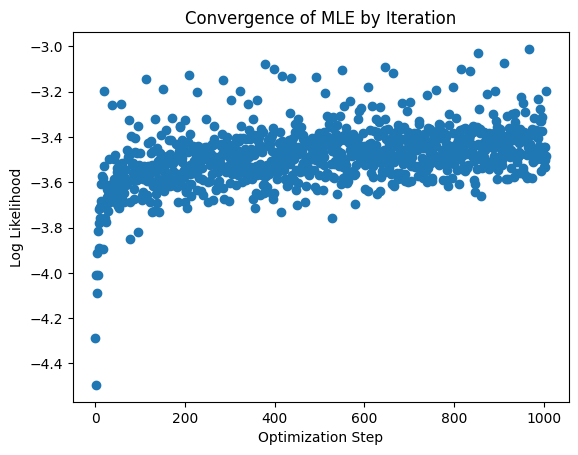

In [754]:
# Scatter plot of convergence (per iteration)
plt.scatter(range(len(log_likelihood_history_iter)), log_likelihood_history_iter)
plt.xlabel('Optimization Step')
plt.ylabel('Log Likelihood')
plt.title('Convergence of MLE by Iteration')
plt.show()

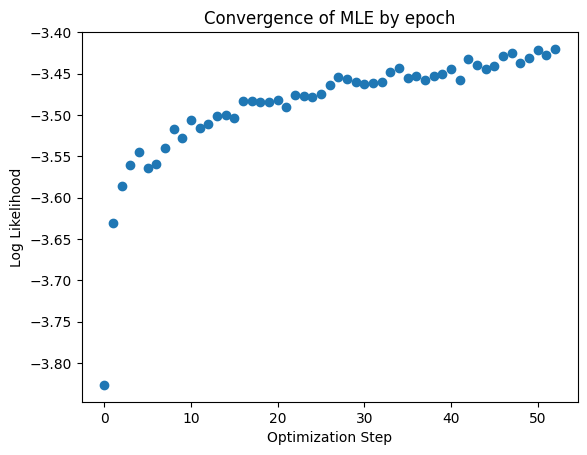

In [755]:
plt.scatter(range(num_epochs), log_likelihood_history)
plt.xlabel('Optimization Step')
plt.ylabel('Log Likelihood')

plt.title('Convergence of MLE by epoch')
plt.show()

In [756]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_retrieval(test_smell_data, test_smell_label, gcms_encoder, sensor_encoder, device='cpu'):
    """
    Evaluate how well the model matches GCMS embeddings to sensor embeddings.
    We'll compute:
      - embeddings for all GCMS data
      - embeddings for all sensor data
    Then for each GCMS embedding, we find the most similar sensor embedding
    and check if it's the correct one (same sample index).

    This returns the "retrieval accuracy" (% of rows i where argmax similarity == i).

    Parameters:
      test_loader: a DataLoader that yields (x_gcms, x_sensor) for test samples.
                   We assume each batch is aligned so sample i in both is the "same" sample.
      gcms_encoder, sensor_encoder: your trained PyTorch encoders
      device: 'cpu' or 'cuda'
    """
    gcms_encoder.eval()
    sensor_encoder.eval()

    # We'll store all embeddings in lists, then concatenate.
    all_z_gcms = []
    all_z_sensor = []

    testing_gcms_data = torch.tensor(gcms_data, dtype=torch.float).to(device)
    gcms_embeddings = gcms_encoder(testing_gcms_data)
    z_gcms = F.normalize(gcms_embeddings, dim=1)

    test_smell_data = torch.tensor(test_smell_data, dtype=torch.float).to(device)
    smell_embeddings = sensor_encoder(test_smell_data)
    z_smell = F.normalize(smell_embeddings, dim=1)

    sim = torch.matmul(z_smell, z_gcms.T)

    print(sim)

    print(f"Similarity matrix shape: {sim.shape}")

    # For each row i, find the column j with the highest similarity
    # If j == i, it means we matched the correct sensor embedding
    predicted = sim.argmax(dim=1)  # [N]

    print("------------------Predictions---------------------")
    print(predicted)

    # Compare with the "ground truth" index = i
    correct = (predicted == test_smell_label)
    accuracy = correct.float().mean().item()

    precision = precision_score(test_smell_label, predicted, average='macro')
    recall = recall_score(test_smell_label, predicted, average='macro')
    f1 = f1_score(test_smell_label, predicted, average='macro')
    conf_matrix = confusion_matrix(test_smell_label, predicted)

    print("------------------Test Statistics---------------------")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, conf_matrix

test_smell_data = remaining_data.drop(['label', 'State'], axis=1).values  # Features
test_y = remaining_data['label'].values  # Labels

accuracy, conf_matrix = evaluate_retrieval(test_smell_data, test_y, gcms_encoder, sensor_encoder, device=device)
print(f"Test retrieval accuracy: {accuracy*100:.2f}%")

tensor([[-0.1826, -0.3393,  0.0653,  0.1856],
        [-0.1611, -0.3795,  0.1191,  0.1620],
        [-0.0517, -0.2778,  0.1073,  0.1872],
        ...,
        [ 0.1387,  0.1606,  0.0599, -0.1394],
        [-0.0248,  0.1032,  0.1484,  0.1301],
        [ 0.1869,  0.1270,  0.0225, -0.1246]], grad_fn=<MmBackward0>)
Similarity matrix shape: torch.Size([11132, 4])
------------------Predictions---------------------
tensor([3, 3, 3,  ..., 1, 2, 0])
------------------Test Statistics---------------------
Accuracy: 0.6301
Precision: 0.5843
Recall: 0.5932
F1-Score: 0.5816
Confusion Matrix:
[[3352 1262  499  108]
 [ 443 2229  161   54]
 [ 147  425  804  413]
 [ 137   93  376  629]]
Test retrieval accuracy: 63.01%


In [757]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def analyze_confusion_matrix(conf_matrix):
    num_classes = conf_matrix.shape[0]
    class_metrics = {}

    # Calculate metrics for each class
    for i in range(num_classes):
        # True Positives (TP): Correct predictions for class i
        num_predictions = np.sum(conf_matrix[i])
        TP = conf_matrix[i, i]

        # False Positives (FP): Sum of column i (excluding TP)
        FP = np.sum(conf_matrix[:, i]) - TP

        # False Negatives (FN): Sum of row i (excluding TP)
        FN = np.sum(conf_matrix[i, :]) - TP

        # True Negatives (TN): Sum of all elements except row i and column i
        TN = np.sum(conf_matrix) - (TP + FP + FN)

        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        precision = TP / num_predictions

        # Store metrics for the class
        class_metrics[available_food_names[i]] = {
            "Accuracy": precision,
        }

    return class_metrics

analyze_confusion_matrix(conf_matrix)

{'cloves': {'Accuracy': np.float64(0.6420226010342847)},
 'cumin': {'Accuracy': np.float64(0.772081745756841)},
 'oregano': {'Accuracy': np.float64(0.4494130799329234)},
 'ambient': {'Accuracy': np.float64(0.5093117408906883)}}

In [758]:
from datetime import datetime

In [759]:
train_mean

array([3.24844059, 5.19711953, 3.36944064])

In [760]:
train_std

array([4.36987303, 5.62808839, 3.45944039])

In [761]:
import os
from datetime import datetime

# Define model save directory
# model_dir = "/Users/evangelinewang/Desktop/Smell Project/demo_1/Past_Model_Testing/smell_demo/demo_1/model"
model_dir = "model"


# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Generate model paths with timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
gcms_model_path = os.path.join(model_dir, f"demo_gcms_encoder_{timestamp}.pt")
sensor_model_path = os.path.join(model_dir, f"demo_sensor_encoder_{timestamp}.pt")

# Save models
torch.save(gcms_encoder.state_dict(), gcms_model_path)
torch.save(sensor_encoder.state_dict(), sensor_model_path)

print(f"Models saved:")
print(f"  GCMS encoder: {gcms_model_path}")
print(f"  Sensor encoder: {sensor_model_path}")

Models saved:
  GCMS encoder: model/demo_gcms_encoder_2025-10-22_04-28-38.pt
  Sensor encoder: model/demo_sensor_encoder_2025-10-22_04-28-38.pt


In [762]:
# Model Hooks
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
from typing import Dict

def load_model():
    """
    Load the trained contrastive learning models and reference database.
    
    Returns:
        dict:
        - 'sensor_encoder': trained sensor encoder
        - 'gcms_encoder': trained GCMS encoder  
        - 'reference_gcms': tensor of reference GCMS profiles
        - 'reference_labels': list of labels for reference profiles
        - 'device': torch device
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model directory
    model_dir = "model"
    
    # Load the models with updated file paths
    gcms_model_path = os.path.join(model_dir, "demo_gcms_encoder_2025-10-22_03-25-27.pt")
    sensor_model_path = os.path.join(model_dir, "demo_sensor_encoder_2025-10-22_03-25-27.pt")
    
    # Recreate model architecture (adjust dimensions as needed)
    sensor_input_dim = 4  # NO2, C2H5OH, VOC, CO
    gcms_input_dim = 10
    embedding_dim = 128  # Should match training configuration
    output_dim = 16 
    
    sensor_encoder = SensorDataEncoder(input_dim=sensor_input_dim, hidden_dim=embedding_dim, output_dim = output_dim)
    gcms_encoder = GCMSDataEncoder(input_dim=gcms_input_dim, hidden_dim=embedding_dim, output_dim = output_dim)
    
    # Load weights
    sensor_encoder.load_state_dict(torch.load(sensor_model_path, map_location=device))
    gcms_encoder.load_state_dict(torch.load(gcms_model_path, map_location=device))
    
    # Move to device and set to eval mode
    sensor_encoder.to(device).eval()
    gcms_encoder.to(device).eval()
    
    # Load reference GCMS database
    # Replace with your actual reference data loading
    reference_gcms, reference_labels = load_reference_database()
    reference_gcms = reference_gcms.to(device)
    
    return {
        'sensor_encoder': sensor_encoder,
        'gcms_encoder': gcms_encoder,
        'reference_gcms': reference_gcms,
        'reference_labels': reference_labels,
        'device': device
    }


def load_reference_database():
    """
    Load reference GCMS profiles and their labels.
    
    Returns:
        tuple: (reference_gcms_tensor, reference_labels_list)
    """
    # Load GCMS dataframe
    df = pd.read_csv("gcms_dataframe.csv")
    
    # Add ambient row
    ambient_row = pd.DataFrame([{
        'food_name': "ambient", 
        'C': 0.04, 'Ca': 0, 'H': 0.00005, 'K': 0, 
        'Mg': 0, 'N': 78.08, 'Na': 0, 'O': 20.95, 
        'P': 0, 'Se': 0
    }])
    df = pd.concat([df, ambient_row], ignore_index=True)
    
    # Filter to available foods
    top_5_food = ["oregano", "cumin", "cloves", "ambient"]
    df = df[df['food_name'].isin(top_5_food)]
    
    # Extract labels before dropping
    reference_labels = df["food_name"].to_list()
    
    # Get numerical data
    df_dropped = df.drop(columns=["food_name"], errors="ignore")
    gcms_data = df_dropped.values
    
    # Normalize
    scaler = StandardScaler()
    gcms_data = scaler.fit_transform(gcms_data)
    
    # Convert to tensor
    reference_gcms = torch.tensor(gcms_data, dtype=torch.float32)
    
    return reference_gcms, reference_labels


def predict_proba_from_dataframe(model: Dict, df: pd.DataFrame, classes: list) -> Dict[str, float]:
    """
    Return dict {class_name: probability} summing to ~1.
    
    Args:
        model: Dict containing encoders and reference data from load_model()
        df: DataFrame with sensor readings (columns: NO2, C2H5OH, VOC, CO, Alcohol, LPG, Benzene)
        classes: List of class names to predict probabilities for
    
    Returns:
        Dict mapping class names to probabilities
    """
    if len(df) == 0:
        # Return uniform distribution if no data
        n = len(classes)
        return {c: 1.0 / n for c in classes}
    
    # Extract components from model dict
    sensor_encoder = model['sensor_encoder']
    gcms_encoder = model['gcms_encoder']
    reference_gcms = model['reference_gcms']
    reference_labels = model['reference_labels']
    device = model['device']
    
    # Prepare sensor data
    sensor_columns = ['NO2', 'C2H5OH', 'VOC', 'CO']
    
    # Take mean of all rows if multiple samples
    sensor_data = torch.tensor(df[sensor_columns].mean(axis=0).values, 
                               dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Encode sensor data
        z_sensor = sensor_encoder(sensor_data)  # [1, embedding_dim]
        
        # Encode reference GCMS profiles
        z_gcms = gcms_encoder(reference_gcms)  # [num_references, embedding_dim]
        
        # Compute cosine similarities
        z_sensor_norm = F.normalize(z_sensor, dim=1)
        z_gcms_norm = F.normalize(z_gcms, dim=1)
        
        similarities = torch.matmul(z_sensor_norm, z_gcms_norm.T).squeeze()  # [num_references]
        
        # Convert similarities to probabilities using softmax with temperature
        temperature = 0.1  # Lower temperature = more confident predictions
        probs = F.softmax(similarities / temperature, dim=0).cpu().numpy()
        
        # Aggregate probabilities by class
        class_probs = {}
        for class_name in classes:
            # Sum probabilities for all reference samples of this class
            class_indices = [i for i, label in enumerate(reference_labels) if label == class_name]
            if class_indices:
                class_probs[class_name] = float(probs[class_indices].sum())
            else:
                class_probs[class_name] = 0.0
        
        # Normalize to ensure sum = 1.0
        total = sum(class_probs.values())
        if total > 0:
            class_probs = {k: v / total for k, v in class_probs.items()}
        else:
            # Fallback to uniform if no matches
            n = len(classes)
            class_probs = {c: 1.0 / n for c in classes}
    
    return class_probs


# Load model once at startup
MODEL = load_model()


# Example usage:
classes = ['cloves', 'cumin', 'oregano', 'ambient']
df = pd.read_csv("demo_data/testing_data/ambient_glass.124e3fbc8917.csv")
probabilities = predict_proba_from_dataframe(MODEL, df, classes)
print(probabilities)
# >>> {'cloves': 0.65, 'cumin': 0.25, 'oregano': 0.08, 'ambient': 0.02}

RuntimeError: Error(s) in loading state_dict for SensorDataEncoder:
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 3]) from checkpoint, the shape in current model is torch.Size([128, 4]).